In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, r2_score
from six import StringIO
import pydotplus
from IPython.display import Image

In [83]:
data = pd.read_csv('data/Carseats.csv', index_col=0).reset_index(drop=True)
df = pd.get_dummies(data, columns=['ShelveLoc', 'Urban', 'US'], drop_first=True)
df

Sales  CompPrice  Income  Advertising  Population  Price  Age  Education  \
0     9.50        138      73           11         276    120   42         17   
1    11.22        111      48           16         260     83   65         10   
2    10.06        113      35           10         269     80   59         12   
3     7.40        117     100            4         466     97   55         14   
4     4.15        141      64            3         340    128   38         13   
..     ...        ...     ...          ...         ...    ...  ...        ...   
395  12.57        138     108           17         203    128   33         14   
396   6.14        139      23            3          37    120   55         11   
397   7.41        162      26           12         368    159   40         18   
398   5.94        100      79            7         284     95   50         12   
399   9.71        134      37            0          27    120   49         16   

     ShelveLoc_Good  ShelveLoc_Medium  Urban_Yes  US_Yes  
0                 0                 0          1       1  
1                 1                 0          1       1  
2                 0                 1          1       1  
3                 0                 1          1       1  
4                 0                 0          1       0  
..              ...               ...        ...     ...  
395               1                 0          1       1  
396               0                 1          0       1  
397               0                 1          1       1  
398               0                 0          1       1  
399               1                 0          1       1  

[400 rows x 12 columns]

In [84]:
X = df.drop(columns='Sales')
y = df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

R2 training score: 1.0000.

MSE training error: 0.0000.

R2 test score: 0.2083.

MSE test error: 6.2144.



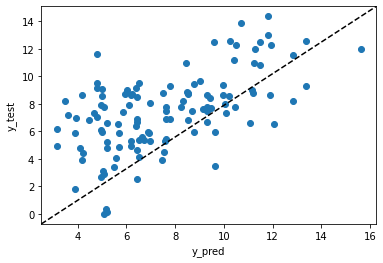

In [95]:
# Create Regression Tree
regr_tree = DecisionTreeRegressor(random_state=1)
regr_tree.fit(X_train, y_train)

# Return R2
print('R2 training score: {:.4f}.\n'.format(regr_tree.score(X_train, y_train)))

# Return MSE training error
print('MSE training error: {:.4f}.\n'.format(mean_squared_error(y_train, regr_tree.predict(X_train))))

# Calculate R2 test score
y_pred = regr_tree.predict(X_test)
print('R2 test score: {:.4f}.\n'.format(r2_score(y_test, y_pred)))

print('MSE test error: {:.4f}.\n'.format(mean_squared_error(y_test, y_pred)))

# Plot Chart y_pred, y_test
# plt.figure(8,6)
plt.scatter(y_pred, y_test, label = 'medv')
plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

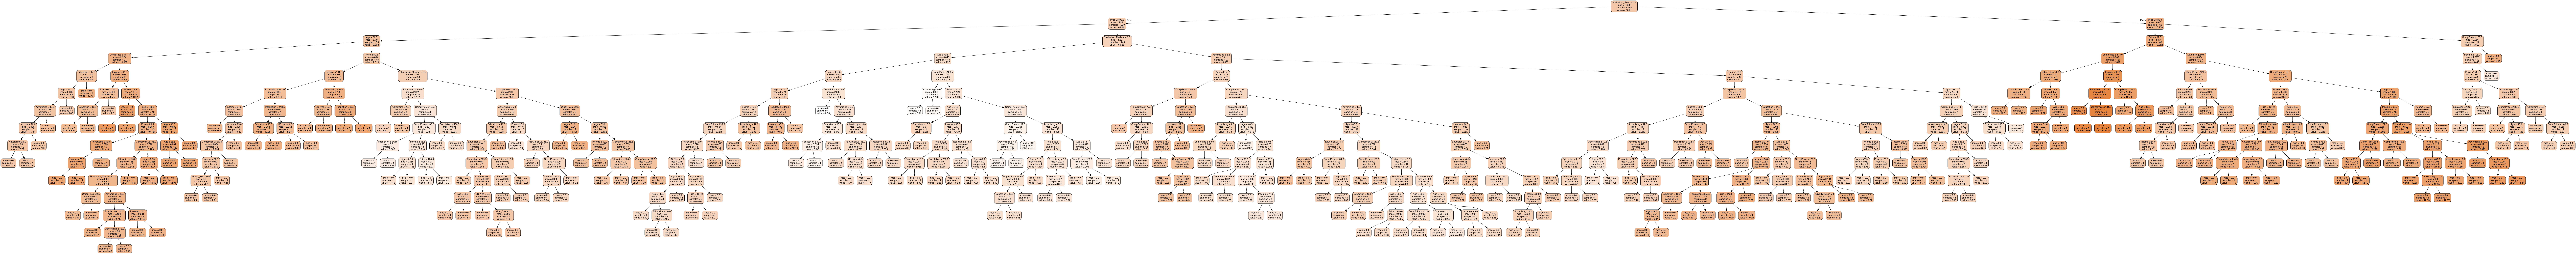

In [96]:
# Create Tree Chart
dot_data = StringIO()

export_graphviz(regr_tree, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=X.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

In [87]:
# Calculate alphas, impurities effective range
regr_tree = DecisionTreeRegressor(random_state=1)
path = regr_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas_train, impurities_tran = path.ccp_alphas, path.impurities

In [88]:
# Draw Chart alphas vs impurities
def display_regr_tree_pruning_result(ccp_alphas, X_train, X_test, y_train, y_test):

    # Create data
    impurity = []
    leaves_counts = []
    train_r2, test_r2 = [], []
    train_mse, test_mse = [], []
    for ccp_alpha in ccp_alphas:

        # Create a list model due to changes of alpha
        regr_tree = DecisionTreeRegressor(ccp_alpha=ccp_alpha, random_state=1)
        regr_tree.fit(X_train, y_train)

        # Append result on node counts, r2, mse
        impurity.append(regr_tree.tree_.impurity.mean())
        leaves_counts.append(regr_tree.tree_.n_leaves)
        train_r2.append(regr_tree.score(X_train, y_train))
        test_r2.append(regr_tree.score(X_test, y_test))
        train_mse.append(mean_squared_error(y_train, regr_tree.predict(X_train)))
        test_mse.append(mean_squared_error(y_test, regr_tree.predict(X_test)))

    # Wrap to numpy array to for easy to manipulate
    impurity = np.array(impurity)
    leaves_counts = np.array(leaves_counts)
    train_r2 = np.array(train_r2)
    test_r2 = np.array(test_r2)
    train_mse = np.array(train_mse)
    test_mse = np.array(test_mse)

    k = test_mse.argmin()
    k_f = k + 5
    k_b = k - 20

    # Start plot data
    plt.figure(figsize=(16,12))

    plot_1 = plt.subplot(2,2,1)
    plt.plot(ccp_alphas[:-1], impurity[:-1], marker='o', drawstyle='steps-post')
    plt.xlabel('Alphas')
    plt.ylabel('Impurities of leaves')
    plt.title('Impurities vs Alphas for training set')

    plot_2 = plt.subplot(2,2,2)
    plt.plot(ccp_alphas[k_b:k_f], leaves_counts[k_b:k_f], drawstyle='steps-post')
    plt.plot(ccp_alphas[k], leaves_counts[k], 'ro', label='At min test MSE, alpha: {:.4f}, number Leaves: {}'.format(ccp_alphas[k], leaves_counts[k]))
    plt.xlabel('Alphas')
    plt.ylabel('Number of Leaves')
    plt.legend()
    plt.title('Number of Leaves vs Alphas for training set')

    plot_3 = plt.subplot(2,2,3)
    plt.plot(ccp_alphas[k_b:k_f], train_r2[k_b:k_f], drawstyle='steps-post', label='train R2')
    plt.plot(ccp_alphas[k_b:k_f], test_r2[k_b:k_f], drawstyle='steps-post', label='test R2')
    plt.plot(ccp_alphas[k], test_r2[k], 'ro', label='Max test R2: {:.4f} at alpha: {:.4f}'.format(test_r2[k], ccp_alphas[k]))
    plt.xlabel('Alphas')
    plt.ylabel('R2')
    plt.legend()
    plt.title('R2 vs Alphas on train-test set')

    plot_4 = plt.subplot(2,2,4)
    plt.plot(ccp_alphas[k_b:k_f], train_mse[k_b:k_f], drawstyle='steps-post', label='train MSE')
    plt.plot(ccp_alphas[k_b:k_f], test_mse[k_b:k_f], drawstyle='steps-post', label='test MSE')
    plt.plot(ccp_alphas[k], test_mse[k], 'ro', label='Min test MSE: {:.4f} at alpha: {:.4f}'.format(test_mse[k], ccp_alphas[k]))
    plt.xlabel('Alphas')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('MSE vs Alphas on train-test set')

    plt.show()

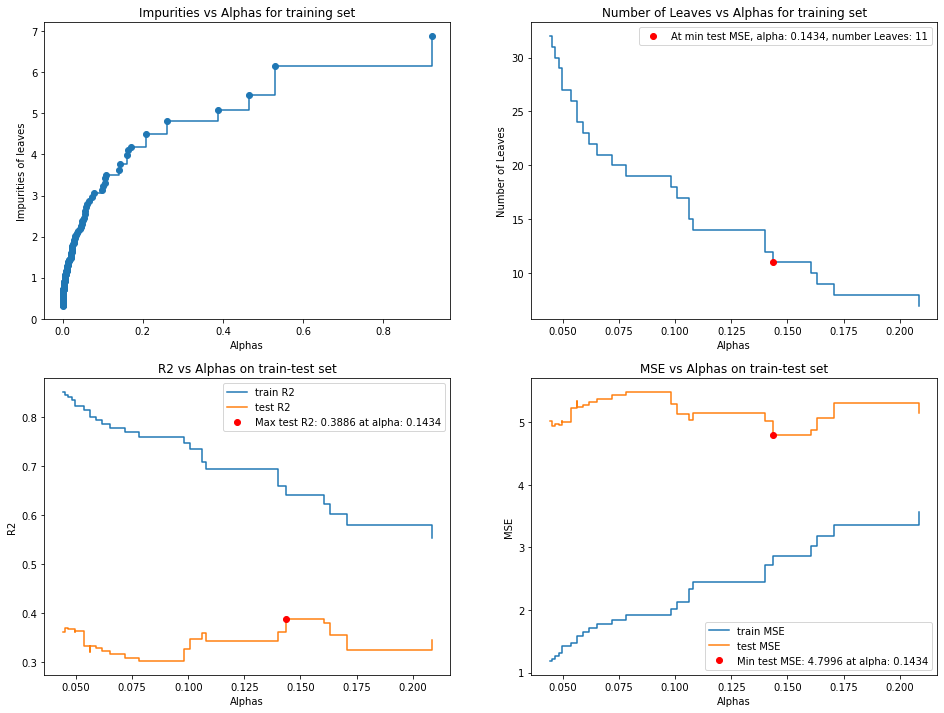

In [89]:
display_regr_tree_pruning_result(ccp_alphas_train, X_train, X_test, y_train, y_test)

In [90]:
# Calculate optimal alpha for Pruning Tree by using Cross-validation
def display_regr_tree_pruning_cv_result(ccp_alphas, X, y):
    global ccp_alphas_optimal

    cv = KFold(n_splits=10, shuffle=True, random_state=2)

    # Create data
    train_r2 = []
    test_r2 = []
    train_mse = []
    test_mse = []
    for ccp_alpha in ccp_alphas:

        # Create a list model due to changes of alpha
        regr_tree = DecisionTreeRegressor(ccp_alpha=ccp_alpha, random_state=1)
        score = cross_validate(regr_tree, X, y, cv=cv, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

        # Append result mean r2, mse
        train_r2.append(np.mean(score['train_r2']))
        test_r2.append(np.mean(score['test_r2']))
        train_mse.append(np.mean(np.abs(score['train_neg_mean_squared_error'])))
        test_mse.append(np.mean(np.abs(score['test_neg_mean_squared_error'])))

    # Wrap to numpy array to for easy to manipulate
    train_r2 = np.array(train_r2)
    test_r2 = np.array(test_r2)
    train_mse = np.array(train_mse)
    test_mse = np.array(test_mse)

    k = test_mse.argmin()
    k_f_bound = len(test_mse)-1-k
    k_f = k + k_f_bound
    k_b = k - k

    ccp_alphas_optimal = ccp_alphas[k]
    optimal_regr_tree = DecisionTreeRegressor(random_state=1, ccp_alpha=ccp_alphas[k]).fit(X, y)
    leaves = optimal_regr_tree.tree_.n_leaves

    # Start plot data
    plt.figure(figsize=(16,6))

    plot_1 = plt.subplot(1,2,1)
    plt.plot(ccp_alphas[k_b:k_f], train_r2[k_b:k_f], drawstyle='steps-post', label='train R2')
    plt.plot(ccp_alphas[k_b:k_f], test_r2[k_b:k_f], label='test R2')
    plt.plot(ccp_alphas[k], test_r2[k], 'ro', label='Max test R2: {:.4f} at alpha: {:.4f}, {} leaves'.format(test_r2[k], ccp_alphas[k], leaves))
    plt.xlabel('Alphas')
    plt.ylabel('R2')
    plt.legend()
    plt.title('R2 test set')

    plot_2 = plt.subplot(1,2,2)
    plt.plot(ccp_alphas[k_b:k_f], train_mse[k_b:k_f], drawstyle='steps-post', label='train MSE')
    plt.plot(ccp_alphas[k_b:k_f], test_mse[k_b:k_f], label='test MSE')
    plt.plot(ccp_alphas[k], test_mse[k], 'ro', label='Min test MSE: {:.4f} at alpha: {:.4f}, {} leaves'.format(test_mse[k], ccp_alphas[k], leaves))
    plt.xlabel('Alphas')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('MSE test-error')

    plt.show()

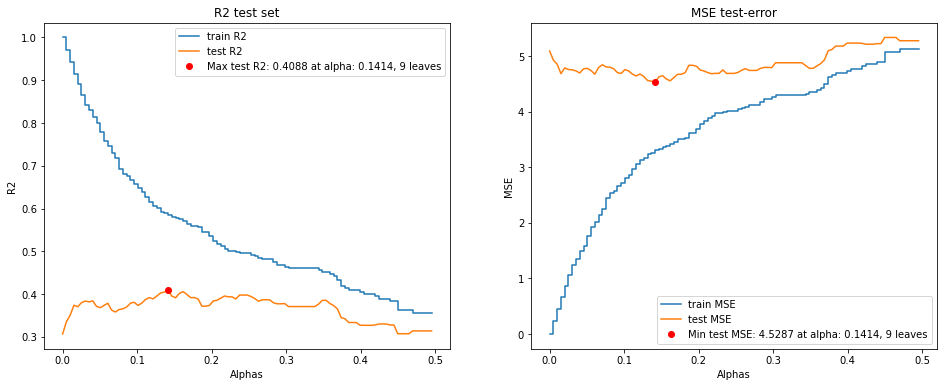

In [91]:
ccp_alphas_cv = np.linspace(0,0.5,100)
ccp_alphas_optimal = 0
display_regr_tree_pruning_cv_result(ccp_alphas_cv, X, y)

In [92]:
ccp_alphas_optimal

0.14141414141414144

Number of Leaves nodes: 12.

R2 training score: 0.6600.

MSE training error: 2.7199.

R2 test score: 0.3608.

MSE test error: 5.0175.



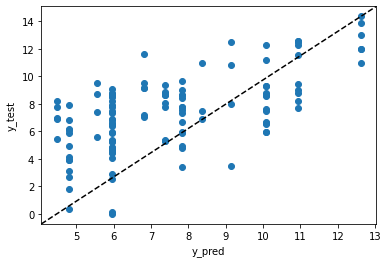

In [93]:
# Create Regression Tree
regr_tree = DecisionTreeRegressor(ccp_alpha=ccp_alphas_optimal, random_state=1)
regr_tree.fit(X_train, y_train)
print('Number of Leaves nodes: {}.\n'.format(regr_tree.tree_.n_leaves))

# Return R2
print('R2 training score: {:.4f}.\n'.format(regr_tree.score(X_train, y_train)))

# Return MSE training error
print('MSE training error: {:.4f}.\n'.format(mean_squared_error(y_train, regr_tree.predict(X_train))))

# Calculate R2 test score
y_pred = regr_tree.predict(X_test)
print('R2 test score: {:.4f}.\n'.format(r2_score(y_test, y_pred)))

print('MSE test error: {:.4f}.\n'.format(mean_squared_error(y_test, y_pred)))

# Plot Chart y_pred, y_test
# plt.figure(8,6)
plt.scatter(y_pred, y_test, label = 'medv')
plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

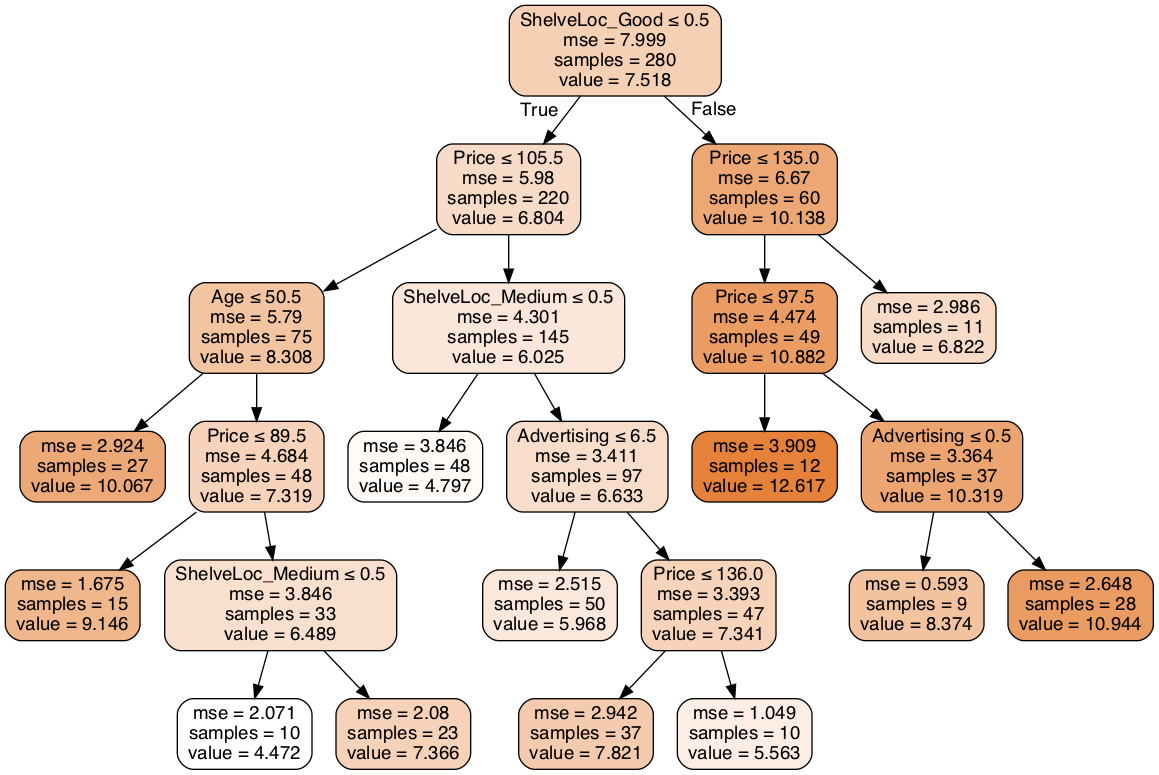

In [94]:
# Create Tree Chart
dot_data = StringIO()

export_graphviz(regr_tree, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=X.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

In [98]:
# Pruning tree improve 16% R2 (20% to 36%) test and drop significant MSE test from (6.2 to 5.0)
# But overall, R2 too small, MSE not drop to small needed amount
# Need bagging or random forests or booting to improve more on prediction

R2 training score: 0.9591

MSE training error: 0.3270

R2 test score: 0.6366

MSE test error: 2.8523



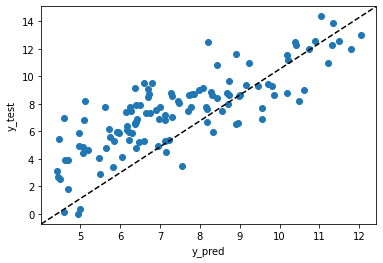

In [103]:
bagging = RandomForestRegressor(random_state=1, n_estimators=500)
bagging.fit(X_train, y_train)

# Return R2
print('R2 training score: {:.4f}'.format(bagging.score(X_train, y_train)))
print('')
# Return MSE training error
print('MSE training error: {:.4f}'.format(mean_squared_error(y_train, bagging.predict(X_train))))
print('')

# Calculate R2 test score
y_pred = bagging.predict(X_test)
print('R2 test score: {:.4f}'.format(r2_score(y_test, y_pred)))
print('')
print('MSE test error: {:.4f}'.format(mean_squared_error(y_test, y_pred)))
print('')

# Plot Chart y_pred, y_test
# plt.figure(8,6)
plt.scatter(y_pred, y_test)
plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

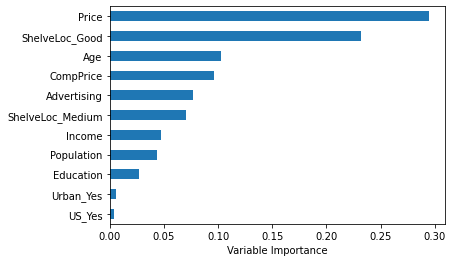

In [105]:
# Create feature importances
feature_importances = pd.DataFrame(bagging.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance').plot(kind='barh')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [104]:
# Bagging improve prediction, test MSE alot, drop to 2.85, R2 test to 63% (nearly double prunning single tree)

R2 training score: 0.9520

MSE training error: 0.3836

R2 test score: 0.6175

MSE test error: 3.0026



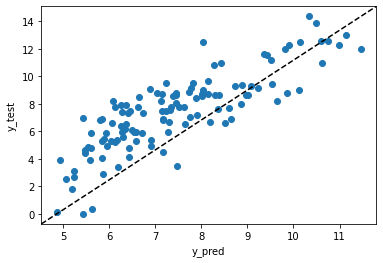

In [117]:
rdn_forests = RandomForestRegressor(max_features='sqrt', random_state=1, n_estimators=500)
rdn_forests.fit(X_train, y_train)

# Return R2
print('R2 training score: {:.4f}'.format(rdn_forests.score(X_train, y_train)))
print('')
# Return MSE training error
print('MSE training error: {:.4f}'.format(mean_squared_error(y_train, rdn_forests.predict(X_train))))
print('')

# Calculate R2 test score
y_pred = rdn_forests.predict(X_test)
print('R2 test score: {:.4f}'.format(r2_score(y_test, y_pred)))
print('')
print('MSE test error: {:.4f}'.format(mean_squared_error(y_test, y_pred)))
print('')

# Plot Chart y_pred, y_test
# plt.figure(8,6)
plt.scatter(y_pred, y_test)
plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

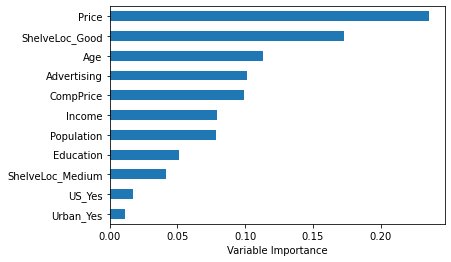

In [118]:
# Create feature importances
feature_importances = pd.DataFrame(rdn_forests.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance').plot(kind='barh')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [119]:
# Result nearly like bagging

In [124]:
# Result performing Random Forest at difference number of Trees, at multiple number features use
cv = KFold(n_splits=10, shuffle=True, random_state=1)
mse_bagging = pd.Series([])
mse_rdn_forests_1 = pd.Series([])
mse_rdn_forests_2 = pd.Series([])
for i in range(1,301):
    
    bagging = RandomForestRegressor(random_state=1, n_estimators=i)
    random_forest_1 = RandomForestRegressor(max_features=6, random_state=1, n_estimators=i)
    random_forest_2 = RandomForestRegressor(max_features='sqrt', random_state=1, n_estimators=i)

    score_bagging = cross_val_score(bagging, X, y, scoring='neg_mean_squared_error')
    score_rdn_forests_1 = cross_val_score(random_forest_1, X, y, scoring='neg_mean_squared_error')
    score_rdn_forests_2 = cross_val_score(random_forest_2, X, y, scoring='neg_mean_squared_error')

    mse_bagging.loc[i] = np.mean(np.abs(score_bagging))
    mse_rdn_forests_1.loc[i] = np.mean(np.abs(score_rdn_forests_1))
    mse_rdn_forests_2.loc[i] = np.mean(np.abs(score_rdn_forests_2))

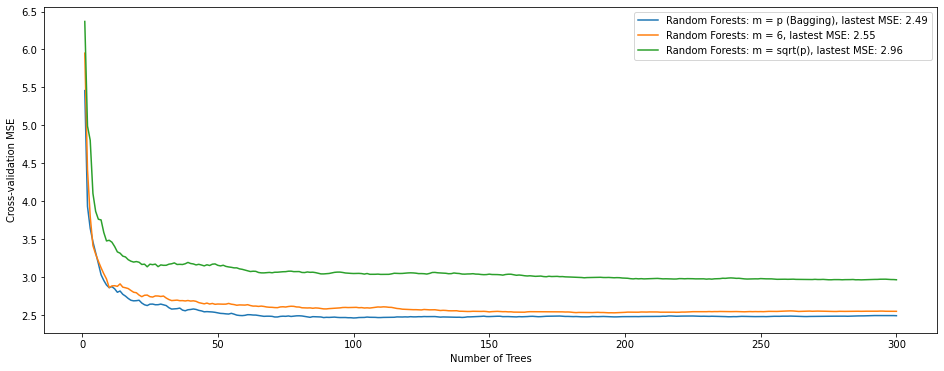

In [125]:
plt.figure(figsize=(16,6))
plt.plot(mse_bagging.index, mse_bagging, label='Random Forests: m = p (Bagging), lastest MSE: {:.2f}'.format(mse_bagging[300]))
plt.plot(mse_rdn_forests_1.index, mse_rdn_forests_1, label='Random Forests: m = 6, lastest MSE: {:.2f}'.format(mse_rdn_forests_1[300]))
plt.plot(mse_rdn_forests_2.index, mse_rdn_forests_2, label='Random Forests: m = sqrt(p), lastest MSE: {:.2f}'.format(mse_rdn_forests_2[300]))
plt.xlabel('Number of Trees')
plt.ylabel('Cross-validation MSE')
plt.legend()
plt.show()

In [123]:
# Bagging seem work best